### Pairs Trading Strategy
#### By Lucas Lara

##### Pairs trading is a form of mean-reversion that has a distinct advantage of always being hedged against market movements. It is generally a high alpha strategy when backed up by some rigorous statistics. The strategy is based on mathematical analysis.

##### The prinicple is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it.

In [1]:
# whoever needs: pip install plotly statsmodels
# to run the last 4 lines
import pandas as pd 
import numpy as np 
import yfinance as yf 
from datetime import datetime, timedelta 
import plotly.express as px 
import plotly.graph_objects as go
from statsmodels.regression.linear_model import OLS 
from statsmodels.regression.rolling import RollingOLS
from plotly.subplots import make_subplots
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller

#### Descargamos los datos de Yahoo Finance

In [2]:
# in sample:
start_is = datetime(2015, 1, 1)
end_is = datetime (2021, 12, 31)
y_is, x_is = "COPEC.SN", "CMPC.SN"
data_is = yf.download([y_is, x_is], start_is, end_is, progress = False) ["Adj Close"]
data_is.columns = ["COPEC", "CMPC"]

In [3]:
# out sample:

start_os = datetime(2022, 1, 1)
end_os = datetime (2023, 12, 12)
y_os, x_os = "COPEC.SN", "CMPC.SN"
data_os = yf.download([y_os, x_os], start_os, end_os, progress = False) ["Adj Close"]
data_os.columns = ["COPEC", "CMPC"]

In [4]:
# consolidado:
start = datetime(2015, 1, 1)
end = datetime (2023, 12, 12)
y, x = "COPEC.SN", "CMPC.SN"
data = yf.download([y, x], start, end, progress = False) ["Adj Close"]
data.columns = ["COPEC", "CMPC"]

In [5]:
# acá mostramos un histograma de los retornos del consolidado para hacer una idea general

returns = data.pct_change ().dropna ()

fig_copec = px.histogram(returns["COPEC"])
fig_cmpc = px.histogram(returns["CMPC"])


fig = make_subplots(rows=1, cols=2, subplot_titles=['COPEC', 'CMPC'])
fig.add_trace(fig_copec.data[0], row=1, col=2)
fig.add_trace(fig_cmpc.data[0], row=1, col=1)
fig.update_layout(width=1000, height=400, title_text='Comparación COPEC Y CMPC')

fig.show()

In [6]:
fig = px.line(returns)
fig.show()
returns.corr()

,COPEC,CMPC
COPEC,1.000000,0.638306
CMPC,0.638306,1.000000


In [7]:
cumulative_returns = (1 + returns). cumprod() - 1
fig = px.line(100*cumulative_returns, title = "Cumulative Returns")
fig. show()


##### Ahora realizamos para las dos acciones una regresión lineal de la forma:

$ Y = \beta X + \varepsilon$

In [8]:
ratio = data["COPEC"]/data["CMPC"]
fig = px.line(ratio)
fig.show()

##### Regresion lineal:

In [9]:
# in sample

Y_is = data_is.COPEC
X_is = data_is.CMPC
model_is = OLS(Y_is, X_is).fit()
beta_hat_is = model_is.params.iloc[0]
beta_hat_is

0.22990000427880947

In [10]:
# out sample

Y_os = data_os.COPEC
X_os = data_os.CMPC
model_os = OLS(Y_os, X_os).fit()
beta_hat_os = model_os.params.iloc[0]
beta_hat_os

0.23314459413644312

In [11]:
# consolidado

Y = data.COPEC
X = data.CMPC
model = OLS(Y, X).fit()
beta_hat = model.params.iloc[0]
beta_hat

0.23045318709148882

In [12]:
# in sample

residuales_is = Y_is - beta_hat_is*X_is
fig_is = px.line(residuales_is)
fig_is.show()

fig2 = px.histogram(residuales_is)
fig2.show()

In [13]:
# out sample

residuales_os = Y_os - beta_hat_os*X_os
fig = px.line(residuales_os)
fig.show()

fig2 = px.histogram(residuales_os)
fig2.show()

In [14]:
# consolidado

residuales = Y - beta_hat*X
fig = px.line(residuales)
fig.show()

fig2 = px.histogram(residuales)
fig2.show()

In [15]:
# in sample
lookback = 60
rolling_is = RollingOLS(Y_is, X_is, window = lookback).fit()
rolling_beta_is = rolling_is.params
rolling_beta_is = rolling_beta_is.bfill()

In [16]:
# in sample
fig = px.line(rolling_beta_is)
fig.show()

In [17]:
# out sample
lookback = 60
rolling_os = RollingOLS(Y_os, X_os, window = lookback).fit()
rolling_beta_os = rolling_os.params
rolling_beta_os = rolling_beta_os.bfill()

In [18]:
# outsample
fig = px.line(rolling_beta_os)
fig.show()

In [19]:
# consolidado
lookback = 60
rolling = RollingOLS(Y, X, window = lookback).fit()
rolling_beta = rolling.params
rolling_beta = rolling_beta.bfill()

In [20]:
# consolidado
fig = px.line(rolling_beta)
fig.show()

In [21]:
# in sample
# ahora rolling residuales para CMPC
rolling_residuales_is = Y_is - rolling_beta_is["CMPC"]*X_is
fig = px. line(rolling_residuales_is)
fig. show()

In [22]:
# out sample
# ahora rolling residuales para CMPC
rolling_residuales_os = Y_os - rolling_beta_os["CMPC"]*X_os
fig = px. line(rolling_residuales_os)
fig. show()

In [23]:
# consolidado
# ahora rolling residuales para CMPC
rolling_residuales = Y - rolling_beta["CMPC"]*X
fig = px. line(rolling_residuales)
fig. show()

In [24]:
# in sample:

test_df_copec_is = adfuller(residuales_is)
test_df_cmpc_is = adfuller(rolling_residuales_is)

# Imprimir el resultado
print('Estadístico de prueba copec:', test_df_copec_is[0]) 
print('Valor p copec:', test_df_copec_is[1]) #Al 5% no se rechaza la hipotesis nula p = 0.096 > -2.86
#por lo tanto la serie puede ser estacionaria

print('Valores críticos copec:', test_df_copec_is[4])

print('Estadístico de prueba cmpc:', test_df_cmpc_is[0])
print('Valor p cmpc:', test_df_cmpc_is[1]) #Al 5% no se rechaza la hipotesis nula p = 9.53 * e^-7 > -2.86; 
#por lo tanto la serie puede ser estacionaria
print('Valores críticos cmpc:', test_df_cmpc_is[4])

Estadístico de prueba copec: -2.584775215885256
Valor p copec: 0.09618492454567018
Valores críticos copec: {'1%': -3.4341137777946718, '5%': -2.8632024980220288, '10%': -2.56765506572863}
Estadístico de prueba cmpc: -5.6608615781017475
Valor p cmpc: 9.387108479609374e-07
Valores críticos cmpc: {'1%': -3.4341137777946718, '5%': -2.8632024980220288, '10%': -2.56765506572863}


In [25]:
# out sample:

test_df_copec_os = adfuller(residuales_os)
test_df_cmpc_os = adfuller(rolling_residuales_os)

# Imprimir el resultado
print('Estadístico de prueba copec:', test_df_copec_os[0]) 
print('Valor p copec:', test_df_copec_os[1]) #Al 5% no se rechaza la hipotesis nula p = 0.096 > -2.86
#por lo tanto la serie puede ser estacionaria

print('Valores críticos copec:', test_df_copec_os[4])

print('Estadístico de prueba cmpc:', test_df_cmpc_os[0])
print('Valor p cmpc:', test_df_cmpc_os[1]) #Al 5% no se rechaza la hipotesis nula p = 9.53 * e^-7 > -2.86; 
#por lo tanto la serie puede ser estacionaria
print('Valores críticos cmpc:', test_df_cmpc_os[4])

Estadístico de prueba copec: -0.5744778614331373
Valor p copec: 0.8766453321955248
Valores críticos copec: {'1%': -3.4444305322234365, '5%': -2.8677488864580885, '10%': -2.5700770984781443}
Estadístico de prueba cmpc: -5.434896755601424
Valor p cmpc: 2.8600516559881e-06
Valores críticos cmpc: {'1%': -3.444133731419755, '5%': -2.8676183066831036, '10%': -2.5700075029117166}


In [26]:
# consolidado

test_df_copec = adfuller(residuales)
test_df_cmpc = adfuller(rolling_residuales)

# Imprimir el resultado
print('Estadístico de prueba copec:', test_df_copec[0]) 
print('Valor p copec:', test_df_copec[1]) #Al 5% no se rechaza la hipotesis nula p = 0.096 > -2.86
#por lo tanto la serie puede ser estacionaria

print('Valores críticos copec:', test_df_copec[4])

print('Estadístico de prueba cmpc:', test_df_cmpc[0])
print('Valor p cmpc:', test_df_cmpc[1]) #Al 5% no se rechaza la hipotesis nula p = 9.53 * e^-7 > -2.86; 
#por lo tanto la serie puede ser estacionaria
print('Valores críticos cmpc:', test_df_cmpc[4])

Estadístico de prueba copec: -3.046370317223457
Valor p copec: 0.030785097874172922
Valores críticos copec: {'1%': -3.433293733687656, '5%': -2.862840454978472, '10%': -2.56746229453218}
Estadístico de prueba cmpc: -7.245723053212443
Valor p cmpc: 1.8345198745943699e-10
Valores críticos cmpc: {'1%': -3.4332924091302055, '5%': -2.8628398701165017, '10%': -2.567461983133443}


##### Comentarios: En la fase de in-sample, al evaluar la estacionariedad de los residuales del spread, el test de Augmented Dickey-Fuller (ADF) proporcionó resultados que sugieren cierto grado de estacionariedad. Para Copec, el estadístico de prueba fue de aproximadamente -2.58, con un valor p de alrededor de 0.096. Aunque el valor p se sitúa cerca del umbral del 5%, la hipótesis nula de no estacionariedad no se rechaza de manera concluyente. Esto sugiere que los residuales de Copec podrían ser estacionarios o marginalmente estacionarios.

##### Por otro lado, para CMPC, el estadístico de prueba fue sustancialmente más bajo, alrededor de -5.66, con un valor p extremadamente pequeño (aproximadamente 9.54e-07). Esto indica que rechazamos la hipótesis nula de no estacionariedad para CMPC en la fase de in-sample, sugiriendo que los residuales de CMPC son estacionarios.

##### Al pasar a la fase de out-of-sample, los resultados del test ADF muestran que la estacionariedad de los residuales puede variar. Para Copec, el estadístico de prueba fue de aproximadamente -0.57, y el valor p fue alrededor de 0.877, indicando que no se puede rechazar la hipótesis nula de no estacionariedad. Esto sugiere que los residuales de Copec no exhiben estacionariedad en la muestra de prueba.

##### En contraste, para CMPC en la muestra de prueba, el estadístico de prueba fue de alrededor de -5.43, con un valor p de aproximadamente 2.86e-06. Estos resultados sugieren que los residuales de CMPC mantienen su estacionariedad en la muestra de prueba.

## Z - Score:

##### Es una medida estadística que cuantifica cuántas desviaciones estándar un punto de datos específico está del promedio de un conjunto de datos. (indica si un valor particular está por encima o por debajo del promedio en términos de variabilidad) 
$ Z = \frac{{(X - \mu)}}{\sigma} $


##### Al activarse una señal, ¿qué tradeo?

$ Y = \beta X (spread) $
##### Threshold superior: Señal de venta --> Vender Y, comprar $\beta$ veces X
##### Threshold inferior: Señal de venta --> Comprar Y, vender $\beta$ veces X

##### Esto trae un problema: el $\beta$ va cambiando. Por lo tanto cada día hay que tomar un periodo de tiempo y estimar el hedge.

##### Ajustamos los Thresholds y para simplicidad juntamos el in y out sample

In [27]:
# ahora en adelante trabajamos con los datos consolidados por simplicidad

k=2 # Thresholds

In [28]:
z_score = (rolling_residuales - rolling_residuales.rolling(lookback).mean())/rolling_residuales.rolling(lookback).std()
fig = px.line(z_score, title = "Z-Score")
fig.add_hline(y=k, line_dash="dash", line_color="red", annotation_text="Threshold Superior", annotation_position="top right")
fig.add_hline(y=-k, line_dash="dash", line_color="green", annotation_text="Threshold Inferior", annotation_position="bottom right")
fig.show()

In [29]:
# Posicion de compra
qy = 5
qx=-8
diff_y = 100
diff_x = 25

daily_gain = qy*diff_y + qx*diff_x
daily_gain

300

#### Estrategia
##### Metricas: 
$ P\&L $

In [30]:
strategy_pnl = data["CMPC"]
strategy_pnl_returns = strategy_pnl.pct_change().dropna()
strategy_pnl_cum_returns = (1 + strategy_pnl_returns).cumprod() - 1
fig = px.line(strategy_pnl_cum_returns)
fig.show()

$ Sharpe\ ratio $

$  SR = \frac{{R_p - R_f}}{{\sigma_p}}  $



In [31]:
sharpe = strategy_pnl_returns.mean()*np.sqrt(252)/strategy_pnl_returns.std() # 252 días laborales, sharpe de CMPC
sharpe

0.13232349544421282

In [32]:
diff = data.diff()
positions = pd.DataFrame(0, columns = list(data.columns), index = data.index)
positions

,COPEC,CMPC
Date,,
2015-01-02,0,0
2015-01-05,0,0
2015-01-06,0,0
2015-01-07,0,0
2015-01-08,0,0
...,...,...
2023-12-04,0,0
2023-12-05,0,0
2023-12-06,0,0


##### Función get_signals la cual me indicará si estoy presente en un Threshold: señales de compra y venta

In [33]:
def get_signals(z_score, k):
    if z_score > k:
        return 1  # Señal de compra
    elif z_score < -k:
        return -1  # Señal de venta
    else:
        return 0  # Sin señal


##### Ahora creamos funcion backtest que implementará la estrategia, la cual consiste en vender sl spread si este cruza el threshold superior (vender Y , comprar β X) y comprar el spread si este cruza el threshold inferior. Se pide crear una funci ́on llamada backtest, que reciba un monto inicial para invertir y que retorne las posiciones de cada acci ́on en la estrategia.

/var/folders/d5/gq7zzf6j3lx9vmb_2npsfqxh0000gn/T/ipykernel_21231/3204041366.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




DataFrame con Posiciones y Valor Nominal:
            Posiciones  Nominal execution of excercise
Date                                                  
2015-01-02           0                             0.0
2015-01-05           0                             0.0
2015-01-06           0                             0.0
2015-01-07           0                             0.0
2015-01-08           0                             0.0
...                ...                             ...
2023-12-04           0                             0.0
2023-12-05           0                             0.0
2023-12-06           0                             0.0
2023-12-07           0                             0.0
2023-12-11           0                             0.0

[2228 rows x 2 columns]

Nocional Final: $ 1003626.2843928853


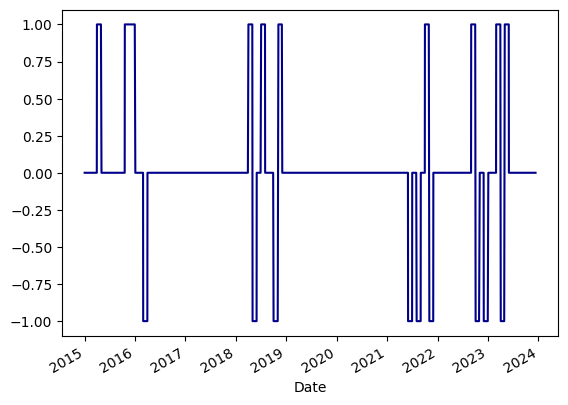

In [34]:
def backtest(nocional, residuales, k):
    positions = pd.DataFrame(index=residuales.index)
    positions["Posiciones"] = 0
    positions["Nominal execution of excercise"] = 0
    capital = nocional
    status = "Waiting"

    for month, data_month in residuales.groupby(residuales.index.to_period("M")):
        señal_mes = 0

        for time in data_month.index:
            señal = get_signals(residuales.loc[time], k)

            if señal != 0:
                señal_mes = señal

        for time in data_month.index:
            if señal_mes != 0:
                if status == "Abierto Arriba" and señal_mes == -1:  # Venta (sell)
                    positions.loc[time, "Posiciones"] = -1
                    capital += residuales.loc[time]  # Asumiendo que vendemos el residuales
                elif status == "Abierto Abajo" and señal_mes == 1:  # Compra (buy)
                    positions.loc[time, "Posiciones"] = 1
                    capital -= residuales.loc[time]  # Asumiendo que compramos el residuales
                else:
                    positions.loc[time, "Posiciones"] = 0
            else:
                positions.loc[time, "Posiciones"] = 0

            positions.loc[time, "Nominal execution of excercise"] = positions.loc[time, "Posiciones"] * residuales.loc[time]

        if data_month.iloc[-1] > k:
            status = "Abierto Arriba"
        elif data_month.iloc[-1] < -k:
            status = "Abierto Abajo"
        else:
            status = "Waiting"

    return positions, capital

# Ejemplo de uso
nocional = 1000000  # Nocional para invertir
k = 2  # Umbral para el Z-Score (ajusta según tu estrategia)
positions, final_nocional = backtest(nocional, residuales, k)

positions["Posiciones"].iloc[200:250] = 1  # Cambiado a 1 para representar "compra"
positions["Posiciones"].plot(color="darkblue")

# Imprimir el DataFrame con las posiciones y el valor nominal
print("\nDataFrame con Posiciones y Valor Nominal:")
print(positions)

print("\nNocional Final: $", final_nocional)

##### Reflejamos el P&L acumulado y sus metricas.

In [35]:
# Calcular PnL de la estrategia
diff = data.diff()
daily_gain = positions["Posiciones"] * diff["CMPC"]
pnl_acumulado = daily_gain.cumsum()

# Calcular métricas
strategy_pnl = data["CMPC"]
strategy_pnl_returns = strategy_pnl.pct_change().dropna()
sharpe_ratio = strategy_pnl_returns.mean()*np.sqrt(252)/strategy_pnl_returns.std() # 252 días laborales, sharpe de CMPC
max_drawdown = (pnl_acumulado / pnl_acumulado.cummax() - 1).min()
cvar = strategy_pnl_returns.quantile(0.05)

# Plotear PnL acumulado
fig = px.line(pnl_acumulado, title="PnL Acumulado de la Estrategia")
fig.show()

# Imprimir métricas
print("Sharpe Ratio:", sharpe_ratio)
print("Max Drawdown:", max_drawdown)
print("CVaR:", cvar)

Sharpe Ratio: 0.13232349544421282
Max Drawdown: -8.445223859210337
CVaR: -0.028251742719925966


## Conclusión y comentarios generales:

##### Resultados KPI: En la evaluación de la estrategia de pair trading implementada a través de trading algorítmico, los indicadores clave de rendimiento (KPIs) proporcionan una visión cuantitativa del desempeño financiero. El Sharpe Ratio, con un valor de 0.1323, señala un rendimiento ajustado al riesgo positivo. Sin embargo, es esencial cuestionar si este rendimiento compensa adecuadamente el riesgo asumido. El Max Drawdown de -8.4452 revela una pérdida máxima experimentada, indicando la importancia de gestionar cuidadosamente las pérdidas. Mientras tanto, el CVaR de -0.0283 representa la pérdida esperada para un nivel de confianza dado, y su magnitud debe interpretarse en relación con otros indicadores de rendimiento.

##### Análisis Detallado: El análisis detallado de los resultados in sample y out sample revela insights cruciales sobre la efectividad de la estrategia. La variabilidad en la estacionariedad de los residuales, evidenciada por el test de Augmented Dickey-Fuller, subraya la importancia de considerar las cambiantes condiciones del mercado. La comparación entre los resultados in sample y out sample sugiere que la estrategia podría haber sido más efectiva durante el periodo de entrenamiento, planteando interrogantes sobre su capacidad para adaptarse a entornos no vistos previamente. Además, la estrategia demuestra ser más efectiva para la acción CMPC que para COPEC, destacando la relevancia de una selección de pares cuidadosa.

##### Problemas y Posibles Soluciones: La estrategia de pair trading enfrenta desafíos notables en su aplicación práctica. La sensibilidad a cambios en las condiciones del mercado presenta una preocupación, ya que afecta la estacionariedad de los residuales. Para abordar esto, se sugiere la implementación de técnicas de adaptabilidad, como la recalibración periódica de parámetros o la exploración de modelos más complejos. El Max Drawdown significativo indica la posibilidad de pérdidas importantes, destacando la necesidad de establecer límites de pérdida y aplicar medidas de gestión de riesgos, como stops automáticos. Además, la asimetría en la efectividad de la estrategia entre diferentes acciones señala la importancia de investigar y ajustar la selección de pares, considerando la dinámica individual de cada instrumento y su relación.

##### En conclusión, la evaluación de la estrategia de pair trading a través del trading algorítmico es un ejercicio complejo que requiere un análisis detallado y una comprensión profunda de la dinámica del mercado. Los KPIs proporcionan una instantánea cuantitativa, pero la interpretación y la mejora continua son esenciales para el éxito a largo plazo. La capacidad de adaptación, la gestión de riesgos y la selección cuidadosa de pares emergen como elementos críticos para mitigar desafíos y optimizar el rendimiento de la estrategia en entornos dinámicos y cambiantes.